In [68]:
# Import Necessary Modules

import glob
import matplotlib.pyplot as plt 
from skimage import io
import numpy as np
%matplotlib inline 

In [69]:
#This function reads in all n images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get a data matrix
#X of size n x 4096. We also generate a -1 label if the row vector corresponds
#to a cat image and a +1 label if the row vector corresponds to a dog image
#and stack these on top of one another to get a label vector y of length n.

def read_data():
    
    #get image filenames
    cat_locs = glob.glob('catsfolder/*.jpg')
    dog_locs = glob.glob('dogsfolder/*.jpg')
    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)

    #initialize empty arrays
    X_cats = np.zeros((num_cats,64*64))
    X_dogs = np.zeros((num_dogs,64*64))
    y_cats = np.zeros((num_cats,1))
    y_dogs = np.zeros((num_dogs,1))
               
    #Load data, reshape into a 1D vector and set labels
    
    keep_track = 0

    for i in range(len(cat_locs)):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_cats[i,:] = im
        y_cats[i] = -1.0
        keep_track += 1

    for i in range(len(dog_locs)):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_dogs[i,:] = im
        y_dogs[i] = 1.0
        keep_track += 1
    
    # combine both datasets
    X = np.append(X_cats,X_dogs,0)
    y = np.append(y_cats,y_dogs)
    
    return X, y 

In [70]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.imshow(image,'gray')

In [71]:
#This function takes in a vector of true labels ytrue
#and a vector of guessed labels yguess and reports back
#the accuracy of the guesses out of 100%.

def calculate_accuracy(ytrue, yguess):
    
    # compare your predictions with the correct labels to determine how many of your predictions were correct.
    correct = sum((ytrue == yguess))
    total = len(ytrue)
    accuracy = 100*float(correct)/float(total)
    # divide the number of correct predictions by the number of total samples to determine your classification accuracy.
    return accuracy

In [72]:
#This function takes in a data matrix X, label vector y, and 
#the desired percentage testpercent. It randomly assigns  
#testpercent of the rows of X and y to Xtest and ytest. 
#The remaining data is assigned to Xtrain and ytrain.

def split_data(X,y,testpercent):
        
    [n, d] = X.shape
    
    ntest = int(round(n*(float(testpercent)/100)))
    ntrain = int(round(n - ntest))
        
    Xtrain = np.zeros((ntrain,d))
    Xtest = np.zeros((ntest,d))
    ytrain = np.zeros((ntrain,1))
    ytest = np.zeros((ntest,1))   
        
    Data = np.column_stack((X,y))
    Data = np.random.permutation(Data)
    
    for i in range(ntest):
        Xtest[i,:] = Data[i,0:d]
        ytest[i] = Data[i,d]
        
    for i in range(ntrain):
        Xtrain[i,:] = Data[i+ntest,0:d]
        ytrain[i] = Data[i+ntest,d]
        
    return Xtrain, ytrain, Xtest, ytest

In [73]:
#This code implements the PCA exactly as in MATLAB so as to be consistent.
#It takes in an n x d data matrix X and returns a d x d orthonormal matrix pcaX. 
#Each column of pcaX contains a basis vector, sorted by decreasing variance.

def pca(X):
    covX = np.cov(X,rowvar=False)
    [Lambda,Vtranspose] = np.linalg.eig(covX)
    neworder = np.argsort(-abs(Lambda))
    pcaX = Vtranspose[:,neworder]
    pcaX = pcaX.real
    return pcaX

In [99]:
#This function takes in a data matrix X and a label
#vector y and outputs the average cat image and average dog image.

def average_pet(X,y):
    cat_index=((y.flatten()-1)).astype(bool)
    dog_index=((y.flatten()+1)).astype(bool)
    catarr=X[cat_index]
    dogarr=X[dog_index]
    avgcat=catarr.mean(axis=0)
    avgdog=dogarr.mean(axis=0)
    return avgcat, avgdog

In [75]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to whether
#each row of Xtest is closer to the average cat or average dog.

def closest_average(Xtrain,ytrain,Xrun):
    avgcat, avgdog=average_pet(Xtrain,ytrain)
    yguess=np.zeros((len(Xrun),1))
    for i in range (len(Xrun)):
        mse_cat = np.square(np.subtract(avgcat,Xrun[i])).mean() 
        mse_dog = np.square(np.subtract(avgdog,Xrun[i])).mean()
        #output the category with least mse
        if mse_dog>mse_cat:
            yguess[i]=-1
        else:
            yguess[i]=1
    return yguess

In [76]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess. Each guess is found
#by searching through Xtrain to find the closest row, and then 
#outputting its label.

def nearest_neighbor(Xtrain,ytrain,Xrun):
    yguess=np.zeros((len(Xrun),1))
    for i in range(len(Xrun)):
        #holds the index that minimizes mse
        min_index=0
        #holds the previous minimum
        min_mse=np.square(np.subtract(Xrun[i],Xtrain[0])).mean()
        for j in range(len(Xtrain)):
            mse = np.square(np.subtract(Xrun[i],Xtrain[j])).mean()
            if mse<min_mse:
                min_index=j
                min_mse=mse
        yguess[i]=ytrain[min_index]
    return yguess

In [94]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute ordinary-least-squares
#vector b. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to the sign
#of the linear prediction.

def linear_regression(Xtrain,ytrain,Xrun):
    #model = LinearRegression()
    #model.fit(Xtrain, ytrain)
    #y_pred = model.predict(Xrun)
    #yguess=np.sign(y_pred)
    b=np.matmul(np.matmul(np.linalg.pinv(np.matmul(Xtrain.T, Xtrain)),Xtrain.T),ytrain)
    y_pred=np.matmul(Xrun,b)
    yguess=np.sign(y_pred)
    return yguess

In [96]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the PCA basis. 
#It also takes in a data matrix Xrun and a dimension k
#and uses the top-k vectors in the PCA basis to reduce the 
#dimension of Xtrain and Xrun. Finally, it uses the reduced data
#as inputs to the linear_regression function to produce 
#a vector of label guesses yguess.

def pca_regression(Xtrain,ytrain,Xrun,k):
    X=np.concatenate((Xtrain, Xrun), axis=0)
    #choose top k basis for Xtrain
    Xtrain_reduced=pca(X.T)[0:len(Xtrain),0:k]
    #choose top k basis for Xrun
    Xrun_reduced=pca(X.T)[len(Xtrain):,0:k]
    yguess=linear_regression(Xtrain_reduced,ytrain,Xrun_reduced)
    return yguess

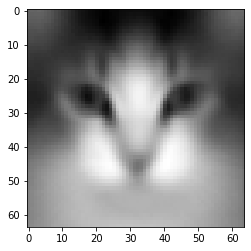

In [100]:
#11.1
X,y = read_data()
avgcat, avgdog=average_pet(X,y)
img=np.zeros((2,4096))
img[0]=avgcat
img[1]=avgdog
show_image(img,0)


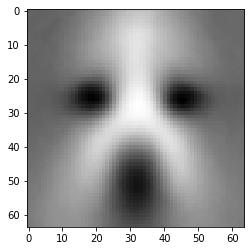

In [101]:
show_image(img,1)

In [102]:
#11.2
yguess=closest_average(Xtrain,ytrain,Xtest)
yguess_train=closest_average(Xtrain,ytrain,Xtrain)
print("training accuracy",calculate_accuracy(ytrain, yguess_train))
print("test accuracy",calculate_accuracy(ytest, yguess))

training accuracy 80.3125
test accuracy 82.0


In [103]:
#11.3
yguess=nearest_neighbor(Xtrain,ytrain,Xtest)
yguess_train=nearest_neighbor(Xtrain,ytrain,Xtrain)
print("training accuracy",calculate_accuracy(ytrain, yguess_train))
print("test accuracy",calculate_accuracy(ytest, yguess))

training accuracy 100.0
test accuracy 80.25


In [104]:
#11.4
yguess=linear_regression(Xtrain,ytrain,Xtest)
yguess_train=linear_regression(Xtrain,ytrain,Xtrain)
print("training accuracy",calculate_accuracy(ytrain, yguess_train))
print("test accuracy",calculate_accuracy(ytest, yguess))

training accuracy 100.0
test accuracy 80.25


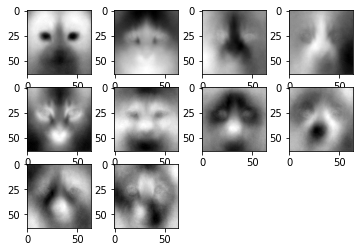

In [117]:
#11.5
pca_Xtrain=pca(Xtrain)
fig=plt.figure()
for i in range(10):
    fig.add_subplot(3,4,i+1)
    show_image(pca_Xtrain.T,i)
#I see shapes of faces. It make senses because every single 
#image is approximately made up of linear combination of these basis

In [118]:
#11.6
print("k=10")
yguess=pca_regression(Xtrain,ytrain,Xtest,10)
yguess_train=pca_regression(Xtrain,ytrain,Xtrain,10)
print("training accuracy",calculate_accuracy(ytrain, yguess_train))
print("test accuracy",calculate_accuracy(ytest, yguess))
print("k=20")
yguess=pca_regression(Xtrain,ytrain,Xtest,20)
yguess_train=pca_regression(Xtrain,ytrain,Xtrain,20)
print("training accuracy",calculate_accuracy(ytrain, yguess_train))
print("test accuracy",calculate_accuracy(ytest, yguess))
print("k=50")
yguess=pca_regression(Xtrain,ytrain,Xtest,50)
yguess_train=pca_regression(Xtrain,ytrain,Xtrain,50)
print("training accuracy",calculate_accuracy(ytrain, yguess_train))
print("test accuracy",calculate_accuracy(ytest, yguess))
print("k=100")
yguess=pca_regression(Xtrain,ytrain,Xtest,100)
yguess_train=pca_regression(Xtrain,ytrain,Xtrain,100)
print("training accuracy",calculate_accuracy(ytrain, yguess_train))
print("test accuracy",calculate_accuracy(ytest, yguess))

k=10
training accuracy 86.1875
test accuracy 85.75
k=20
training accuracy 88.1875
test accuracy 86.5
k=50
training accuracy 92.6875
test accuracy 90.5
k=100
training accuracy 93.9375
test accuracy 93.25
